Want to get rid of systematics from CCDs for weak lensing, so we want the position angle (mod 180 deg) to be as uniform as possible

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metricBundles as metricBundles
from scipy import stats

In [2]:
class uniformKSTest(metrics.BaseMetric):
    """
    Return the KS-test statistic. Values near zero are good, near 1 is bad.
    """
    def __init__(self, paCol = 'rotSkyPos', modVal=180., metricName='uniformKSTest', units='unitless', **kwargs):
        self.paCol = paCol
        self.modVal = modVal
        super(uniformKSTest, self).__init__(col=paCol, metricName=metricName, units=units, **kwargs)
    def run(self, dataSlice, slicePoint=None):
        angleDist = dataSlice[self.paCol] % self.modVal
        ks_D, pVal = stats.kstest(angleDist, 'uniform')
        return ks_D

In [3]:
class KuiperMetric(metrics.BaseMetric):
    """
    Like the KS test, but for periodic things.
    """
    def __init__(self, col='rotSkyPos', cdf=lambda x:x/(2*np.pi), args=(), period=2*np.pi, **kwargs):
        self.cdf = cdf
        self.args = args
        self.period = period
        assert self.cdf(0) == 0.0
        assert self.cdf(self.period) == 1.0
        super(KuiperMetric, self).__init__(col=col, **kwargs)
    def run(self, dataSlice, slicePoint=None):
        data = np.sort(dataSlice[self.colname] % self.period)
        cdfv = self.cdf(data, *self.args)
        N = len(data)
        D = np.amax(cdfv-np.arange(N)/float(N)) + np.amax((np.arange(N)+1)/float(N)-cdfv)
        return D

In [4]:
opsdb = db.OpsimDatabase('minion_1016_sqlite.db')
outDir = 'temp'
resultsDb = db.ResultsDb(outDir=outDir)

In [5]:
slicer = slicers.HealpixSlicer()
sql = 'filter = "g"'
metric = KuiperMetric()
bundle = metricBundles.MetricBundle(metric, slicer, sql)

Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes


Querying database with constraint filter = "g"
Found 246667 visits
Running:  [0]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with filter = "g" constraint now.
monopole: 0.566624  dipole: lon: -43.2686, lat: 63.4699, amp: 0.191727
Plotting complete.


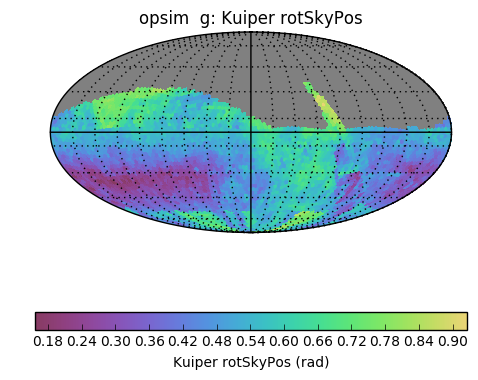

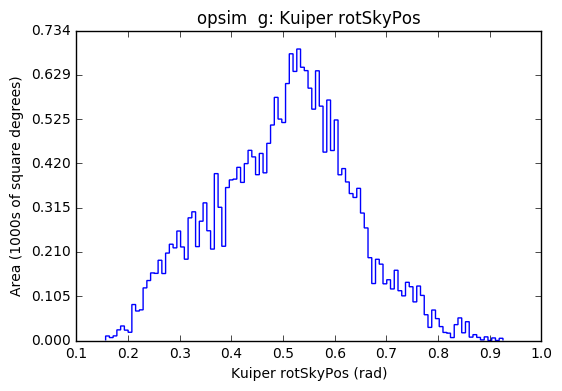

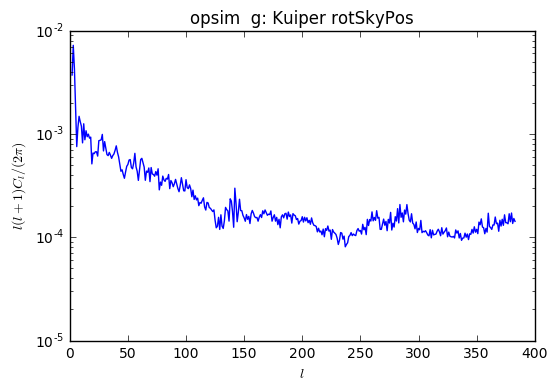

In [6]:
bgroup = metricBundles.MetricBundleGroup({0:bundle}, opsdb, outDir=outDir, resultsDb=resultsDb)
bgroup.runAll()
bgroup.plotAll(closefigs=False)

In [7]:
bundle.metricValues.max()

0.92563747726723467

In [8]:
slicer = slicers.UniSlicer()
sql = 'fieldID=310 and filter="i"'
metric = metrics.PassMetric('rotSkyPos')

In [9]:
bundle = metricBundles.MetricBundle(metric, slicer, sql)
bgroup = metricBundles.MetricBundleGroup({0:bundle}, opsdb, outDir=outDir, resultsDb=resultsDb)
bgroup.runAll()

Querying database with constraint fieldID=310 and filter="i"
Found 204 visits
Running:  [0]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


/Users/yoachim/gitRepos/sims_maf/python/lsst/sims/maf/db/resultsDb.py:282: UserWarning: Warning! Cannot save non-conforming summary statistic.
  warnings.warn('Warning! Cannot save non-conforming summary statistic.')


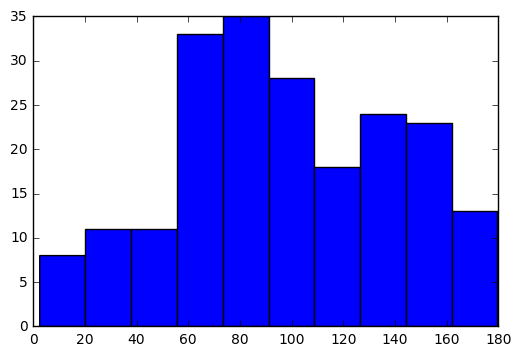

In [10]:
ack = plt.hist(np.degrees(bundle.metricValues[0]['rotSkyPos']) % 180.)

In [11]:
ks = uniformKSTest()
print ks.run(bundle.metricValues[0])

0.843137254902
